# Feature selection on Vestiaire Collective data 

Identify features which best explain the price of an item. 

## Setup

In [23]:
import numpy as np 
import pandas as pd
from pickle import load
import matplotlib.pyplot as plt

In [2]:
from sklearn.ensemble import RandomForestRegressor

In [99]:
from sklearn.inspection import permutation_importance

In [3]:
data_path = "C:/Users/pemma/OneDrive - Université de Tours/Mécen/M2/S1/02 - Machine Learning/05 - Projet/price_prediction_vestiaire_collective/backup/data/"

In [4]:
target = "price"

In [5]:
with open(data_path+"train.pkl", "rb") as file: 
    data = load(file)
X_tr, y_tr = data["X"], data["y"][target]

In [95]:
with open(data_path+"test.pkl", "rb") as file: 
    data = load(file)
X_te, y_te = data["X"], data["y"][target]

In [8]:
with open(data_path+"vc_data_dummies.pkl", "rb") as file: 
    df = load(file)

In [39]:
feature_names = df.drop(
    labels=["price", "lprice", "num_likes", "we_love_tag"], 
    axis=1
).columns

In [40]:
n_features = len(feature_names)

In [18]:
assert len(feature_names) == X_tr.shape[1]

## `RandomForestRegressor`

In [19]:
rf = RandomForestRegressor(
    n_estimators=500, 
    oob_score=True, 
    n_jobs=7
)

In [20]:
rf.fit(X_tr, y_tr)

RandomForestRegressor(n_estimators=500, n_jobs=7, oob_score=True)

In [97]:
rf.score(X_tr, y_tr)

0.6716288659680749

In [96]:
rf.score(X_te, y_te)

0.019856555857948877

## Feature importances

### Feature importance based on Gini impurity 

In [118]:
mdi_importances = pd.DataFrame(
    data={
        "importances": rf.feature_importances_, 
        "std": np.std(
            [
                tree.feature_importances_ 
                for tree in rf.estimators_
            ], 
            axis=0)
    }, 
    index=feature_names
).sort_values(by="importances", ascending=False)

In [119]:
mdi_quantiles = pd.DataFrame.from_dict({
    "q": [str(100-i*10)+"%" for i in range(11)], 
    "val": np.quantile(
        a=mdi_importances.importances, 
        q=np.linspace(0, 1, 11)
    )
}) 

### Feature importance based on feature permutation

In [ ]:
# mean decrease accuracy training set 
mda_test = permutation_importance(
    rf,
    X_tr, 
    y_tr,  
    n_repeats=10, 
    random_state=42, 
    n_jobs=7
)

In [105]:
# mean decrease accuracy testing set 
mda_test = permutation_importance(
    rf,
    X_te, 
    y_te, 
    n_repeats=10, 
    random_state=42, 
    n_jobs=7
)

In [122]:
mda_importances = pd.DataFrame(
    data={
        "importances": mda_test.importances_mean, 
        "std": mda_test.importances_std
    }, 
    index=feature_names
).sort_values(by="importances", ascending=False)

In [124]:
mda_quantiles = pd.DataFrame.from_dict({
    "q": [str(100-i*10)+"%" for i in range(11)], 
    "val": np.quantile(
        a=mda_importances.importances, 
        q=np.linspace(0, 1, 11)
    )
}) 

### Visualize importances

In [120]:
def rf_importances_plot(
    q: str,
    ax: plt.Axes, 
    type: str = "mdi"
): 
    df_quantiles = eval(type+"_quantiles")
    df_importances = eval(type+"_importances")
    mask = df_quantiles.loc[
        df_quantiles.q == q, 
        "val"
    ].values[0]
    df_plot = df_importances[df_importances.importances > mask]
    y_pos = np.arange(df_plot.shape[0])
    ax.barh(
        y_pos, 
        df_plot["importances"], 
        xerr=df_plot["std"], 
        align="center"
    )
    ax.set_yticks(y_pos, labels=df_plot.index)
    ax.set_title(f"The top {q} most important features")
    ax.set_ylabel("Features")
    ax.set_xlabel(f"Mean decrease in {type}")

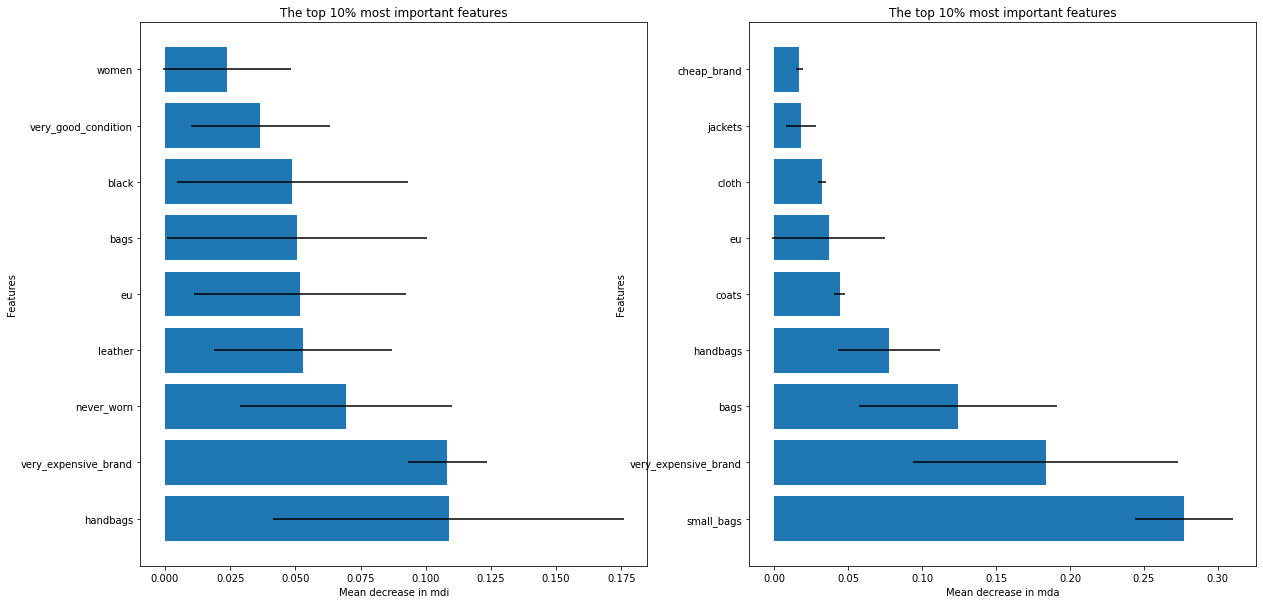

In [127]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(20, 10))
rf_importances_plot(q="10%", ax=ax1)
rf_importances_plot(q="10%", ax=ax2, type="mda")